# *Proyecto final Reconocimiento de rostros*

In [ ]:
# Instalar FaceNet
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.3 MB/s eta 0:00:00


In [ ]:
# Se importan algunas librerías
import os
import sys
import time
import torch
import zipfile
import numpy as np
import imageio
import random
import matplotlib.pyplot as plt
from PIL import Image
from imgaug import augmenters as iaa
from scipy.spatial import distance
from facenet_pytorch import MTCNN, InceptionResnetV1
from pathlib import Path

## Cargar los datos

Extraer los elementos en la carpeta

In [ ]:
#local_zip = '/content/drive/MyDrive/Deep Learning/data.zip' # Si la carpeta se subió por drive (Opción 1)
local_zip = '/content/data.zip' # Si la carpeta se subió por colab (Opción 2)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:
def walk_through_dir(dir_path):
  """
  Camina por la dirección del folder y regresa su contenido.
  Entrada:
    dir_path (str or pathlib.Path): Directorio objetivo
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Hay {len(dirnames)} directorios y {len(filenames)} imágenes en '{dirpath}'.")

In [ ]:
# Definir ruta del conjunto de datos
data_path = Path("/content/data/")
image_path = data_path / "data"
image_path_train = data_path / "data/train"
image_path_test = data_path / "data/test"

In [ ]:
walk_through_dir(image_path)

Hay 2 directorios y 0 imágenes en '/content/data/data'.
Hay 0 directorios y 10 imágenes en '/content/data/data/test'.
Hay 2 directorios y 0 imágenes en '/content/data/data/train'.
Hay 0 directorios y 10 imágenes en '/content/data/data/train/ryan'.
Hay 0 directorios y 10 imágenes en '/content/data/data/train/margot'.


Ruta de la imagen: /content/data/data/train/ryan/im9.png
Clase: ryan
Altura de la imagen: 203
Base de la altura: 222


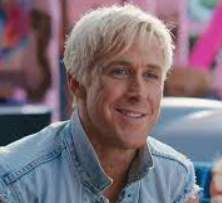

In [ ]:
# Obtner todas las rutas de las imagenes en la lista(* significa cualquier combinación)
image_path_list = list(image_path.glob("*/*/*.png"))
# Obtener una ruta aleatoria
random_image_path = random.choice(image_path_list)
# Obtener la clase de la imagen a partir del nombre de la ruta donde está almacenada
image_class = random_image_path.parent.stem

# Abrir imagen
img = Image.open(random_image_path)

# Print de metadata
print(f"Ruta de la imagen: {random_image_path}")
print(f"Clase: {image_class}")
print(f"Altura de la imagen: {img.height}")
print(f"Base de la altura: {img.width}")
img

In [ ]:
 # Leer todas las imágenes de entrenamiento y pasarlas a un arreglo
images = []
for count,filename in enumerate(list(image_path_train.glob("*/*.png"))):
    print(filename)
    image = imageio.v2.imread(filename, pilmode='RGB')
    images.append(image)
print(f"Número de imágenes de entrenamiento: {len(images)}")

/content/data/data/train/ryan/im8.png
/content/data/data/train/ryan/im10.png
/content/data/data/train/ryan/im7.png
/content/data/data/train/ryan/im2.png
/content/data/data/train/ryan/im9.png
/content/data/data/train/ryan/im5.png
/content/data/data/train/ryan/im6.png
/content/data/data/train/ryan/im1.png
/content/data/data/train/ryan/im3.png
/content/data/data/train/ryan/im4.png
/content/data/data/train/margot/im8.png
/content/data/data/train/margot/im10.png
/content/data/data/train/margot/im7.png
/content/data/data/train/margot/im2.png
/content/data/data/train/margot/im9.png
/content/data/data/train/margot/im5.png
/content/data/data/train/margot/im6.png
/content/data/data/train/margot/im1.png
/content/data/data/train/margot/im3.png
/content/data/data/train/margot/im4.png
Número de imágenes de entrenamiento: 20


In [ ]:
# Selecciona una imagen del arreglo y obtenemos su tamaño
print(f"Tamaño de la imagen: {images[1].shape}")

Tamaño de la imagen: (219, 165, 3)


## Data Augmentation  y extracción de rostros con MTCNN

Se agregan algunas técnicas de data augmentation de la librería imagaug para incrementar el número de imágenes en el conjunto de entrenamiento

In [ ]:
## Data Augmentation
def image_augmentation(image, train=True):
    '''
    Modificar y guarda una imagen con diferentes técnicas de "data augmentation"
    rotación, etc,
    Argumentos:
        - image: numpy array. Imagen
    Salida:
        - Numpy array que contiene las imágenes con las diferentes transformaciones
    '''
    shape = image.shape
    print('image shape:')
    min_dim = min(shape[0:2])
    print(min_dim)

    faces_modified = list() # Crear lista para guardar las transformaciones
    original = iaa.Identity()
    image_original = original.augment_images([image])[0]
    faces_modified.append(image_original)

    if train==True:
        rotate = iaa.Affine(rotate=(-25,25)) # rotate  image
        emboss = iaa.Emboss(alpha=0.5, strength=1.0)
        mirror = iaa.Fliplr(1)
        blur = iaa.MotionBlur(k=int(min_dim/20))
        noise = iaa.AdditiveGaussianNoise(scale=(0, 0.2*255))
        light = iaa.Sharpen(alpha=1.0, lightness=1.5)
        contrast = iaa.LinearContrast(alpha=1.5)
        image_rotate = rotate.augment_images([image])[0]
        faces_modified.append(image_rotate)
        image_emboss = emboss.augment_images([image])[0]
        faces_modified.append(image_emboss)
        image_mirror = mirror.augment_images([image])[0]
        faces_modified.append(image_mirror)
        image_blur = blur.augment_images([image])[0]
        faces_modified.append(image_blur)
        image_noise = noise.augment_images([image])[0]
        faces_modified.append(image_noise)
        image_light = light.augment_images([image])[0]
        faces_modified.append(image_light)
        image_contrast = contrast.augment_images([image])[0]
        faces_modified.append(image_contrast)

    return np.asarray(faces_modified)

In [ ]:
## Extract faces
def convert_Images(array):
    '''
    Convertir array a un objeto Imagen
    '''
    img = Image.fromarray(np.uint8(array), mode='RGB')
    return img

In [ ]:
def extract_faces(model,array):
    '''
    Carga imagenes de un arreglo numpy y recortar el rostro principal en cada imagen
    Argumentos:
        - array: numpy array. Arreglo que contiene las imagenes modificadas
    Salida:
        - faces: Lista de tensores de pytorch con el rostro encontrado en cada imagen
    '''
    faces = list()
    for i in range(0,len(array)):
        img = convert_Images(array[i])
        start_time = time.time()
        model.eval()
        with torch.inference_mode():
            face = model(img)
        print('Tiempo en extraer el rostro de una imagen: ', (time.time() - start_time))
        if face is None:    # En caso de que la imagen no sea un rostro
            continue
        faces.append(face)
    return faces

In [ ]:
def plot_faces(face_list,person, size = 10):
    plt.subplots(figsize=(size, size))
    for i in range(0,len(face_list)):
        plt.subplot(1, len(face_list), i+1)
        face = face_list[i].permute(1,2,0)
        face = (face + 1) / 2.0
        plt.imshow(face)
        plt.axis('off')

In [ ]:
device = 'cpu'

In [ ]:
# Definir red para detectar rostros y cambio a CPU
mtcnn = MTCNN(margin=14, device=device)

In [ ]:
# Data augmentation para data
faces = []

for i,image in enumerate(images):
    print(image.shape)
    faces_aug = image_augmentation(image)
    print('Tamaño del array: ', faces_aug.shape)

    # Detección de rostros
    faces_ext = extract_faces(mtcnn,faces_aug)
    faces.extend(faces_ext)
    plot_faces(faces_ext,'1_'+str(i)) # Visualizar imágenes

In [ ]:
print(f"Número de imágenes: {len(faces)}")

Número de imágenes: 160


In [ ]:
aligned = torch.stack(faces)
print(aligned.shape) # Obtener conjunto de datos

torch.Size([160, 3, 160, 160])


## Extracción de características con FaceNet

In [ ]:
# Red para computar embeddings
resnet = InceptionResnetV1(pretrained='vggface2').to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
start_time = time.time()
resnet.eval()
with torch.inference_mode():
    embeddings  = resnet(aligned)
print('Tiempo en computar los embeddings: ', (time.time() - start_time))
print(f'Tamaño de los emebddings: {embeddings.shape}')

Tiempo en computar los embeddings:  27.427767276763916
Tamaño de los emebddings: torch.Size([160, 512])


In [ ]:
# Transformar vectores embebidos  a un arreglo numpy para poder utilizar scikit-learn
X = embeddings.numpy()
X.shape

(160, 512)

In [ ]:
zero = np.zeros(80)
one = np.ones(80)
y = np.concatenate((zero, one))
y.shape

(160,)

## Parte 1. Clusterización

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
def visualize_dataset(n,x,y):
  '''
  Visualize generated dataset with labels
  - n(int). Number of images to visualize
  - x(numpy_array). Images
  - y(numpy array). Labels
  '''
  plt.figure(figsize=(8,8))
  for i in range(n*n):
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.xlabel(y[i],fontsize = 9, labelpad=0,fontweight='bold')
      plt.subplots_adjust(hspace=0)
  plt.show()

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)

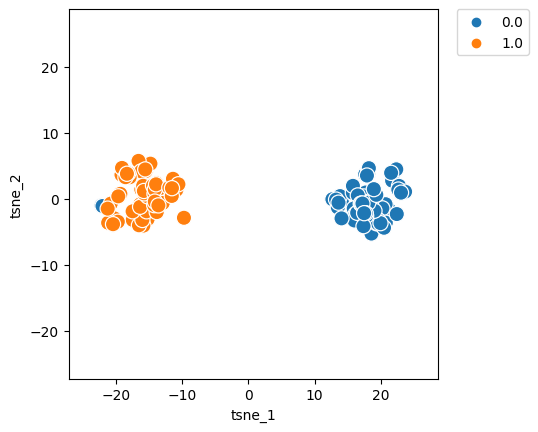

In [ ]:
X_embedded.shape

tsne_result_df = pd.DataFrame({'tsne_1': X_embedded[:,0], 'tsne_2':X_embedded[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (X_embedded.min()-5, X_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## Parte 2. Clasificación


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print('Matriz de confusión')
print(pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True))
print("----------------------------------------------------- ")
print('Metricas de clasificación')
print(classification_report(y_test,y_pred))

Matriz de confusión
Predicted  0.0  1.0  All
True                    
0.0         16    0   16
1.0          0   16   16
All         16   16   32
----------------------------------------------------- 
Metricas de clasificación
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        16

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [ ]:
knn = KNeighborsClassifier(3)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [ ]:
print('Matriz de confusión')
print(pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True))
print("----------------------------------------------------- ")
print('Metricas de clasificación')
print(classification_report(y_test,y_pred))

Matriz de confusión
Predicted  0.0  1.0  All
True                    
0.0         16    0   16
1.0          0   16   16
All         16   16   32
----------------------------------------------------- 
Metricas de clasificación
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        16

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [ ]:
lg = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = lg.predict(X_test)
y_pred

array([1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.])

In [ ]:
y_pred_prob = lg.predict_proba(X_test)
y_pred_prob

array([[0.05850023, 0.94149977],
       [0.08615933, 0.91384067],
       [0.04682144, 0.95317856],
       [0.95191548, 0.04808452],
       [0.05476582, 0.94523418],
       [0.95587534, 0.04412466],
       [0.08015039, 0.91984961],
       [0.96046832, 0.03953168],
       [0.07559303, 0.92440697],
       [0.05666526, 0.94333474],
       [0.96563391, 0.03436609],
       [0.14219636, 0.85780364],
       [0.95460875, 0.04539125],
       [0.94031385, 0.05968615],
       [0.95512136, 0.04487864],
       [0.9470355 , 0.0529645 ],
       [0.03911812, 0.96088188],
       [0.04371843, 0.95628157],
       [0.05717786, 0.94282214],
       [0.96114944, 0.03885056],
       [0.95594016, 0.04405984],
       [0.92414683, 0.07585317],
       [0.91972402, 0.08027598],
       [0.94509251, 0.05490749],
       [0.95351859, 0.04648141],
       [0.05015345, 0.94984655],
       [0.05991605, 0.94008395],
       [0.9684524 , 0.0315476 ],
       [0.03725666, 0.96274334],
       [0.0542726 , 0.9457274 ],
       [0.

## Evaluación con datos nunca antes vistos

In [ ]:
 # Leer todas las imágenes de prueba y pasarlas a un arreglo
images_test = []
for count,filename in enumerate(list(image_path_test.glob("*.png"))):
    print(filename)
    image = imageio.v2.imread(filename, pilmode='RGB')
    images_test.append(image)
print(f"Número de imágenes de entrenamiento: {len(images_test)}")

/content/data/data/test/im8.png
/content/data/data/test/im10.png
/content/data/data/test/im7.png
/content/data/data/test/im2.png
/content/data/data/test/im9.png
/content/data/data/test/im5.png
/content/data/data/test/im6.png
/content/data/data/test/im1.png
/content/data/data/test/im3.png
/content/data/data/test/im4.png
Número de imágenes de entrenamiento: 10


(216, 138, 3)
image shape:
138
Tamaño del array:  (1, 216, 138, 3)
Tiempo en extraer el rostro de una imagen:  0.17496132850646973
(189, 167, 3)
image shape:
167
Tamaño del array:  (1, 189, 167, 3)
Tiempo en extraer el rostro de una imagen:  0.2533900737762451
(161, 140, 3)
image shape:
140
Tamaño del array:  (1, 161, 140, 3)
Tiempo en extraer el rostro de una imagen:  0.07441425323486328
(106, 108, 3)
image shape:
106
Tamaño del array:  (1, 106, 108, 3)
Tiempo en extraer el rostro de una imagen:  0.09063005447387695
(170, 145, 3)
image shape:
145
Tamaño del array:  (1, 170, 145, 3)
Tiempo en extraer el rostro de una imagen:  0.09043359756469727
(182, 140, 3)
image shape:
140
Tamaño del array:  (1, 182, 140, 3)
Tiempo en extraer el rostro de una imagen:  0.0717318058013916
(189, 178, 3)
image shape:
178
Tamaño del array:  (1, 189, 178, 3)
Tiempo en extraer el rostro de una imagen:  0.07398319244384766
(155, 152, 3)
image shape:
152
Tamaño del array:  (1, 155, 152, 3)
Tiempo en extraer 

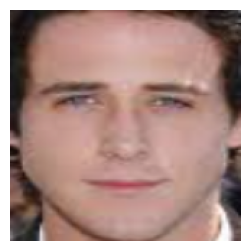

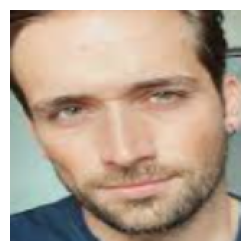

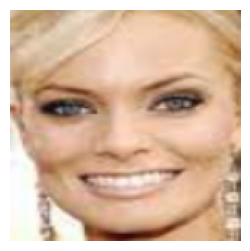

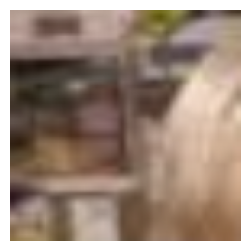

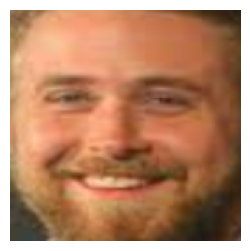

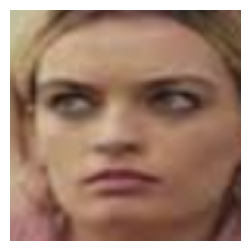

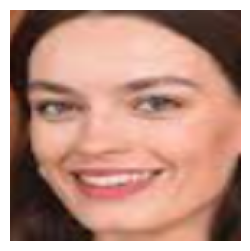

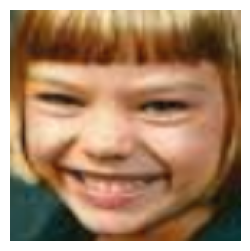

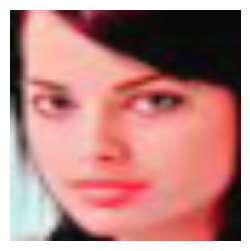

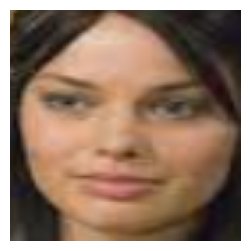

In [ ]:
# Data augmentation para data
faces_test = []

for i,image in enumerate(images_test):
    print(image.shape)
    faces_aug = image_augmentation(image, train=False)
    print('Tamaño del array: ', faces_aug.shape)

    # Detección de rostros
    faces_ext = extract_faces(mtcnn,faces_aug)
    faces_test.extend(faces_ext)
    plot_faces(faces_ext,'1_'+str(i),size=3) # Visualizar imágenes

In [ ]:
aligned_test = torch.stack(faces_test)
print(aligned_test.shape) # Obtener conjunto de datos

torch.Size([10, 3, 160, 160])


In [ ]:
start_time = time.time()
resnet.eval()
with torch.inference_mode():
    embeddings_test  = resnet(aligned_test)
print('Tiempo en computar los embeddings: ', (time.time() - start_time))
print(f'Tamaño de los emebddings: {embeddings_test.shape}')

Tiempo en computar los embeddings:  2.263624906539917
Tamaño de los emebddings: torch.Size([10, 512])


In [ ]:
# Transformar vectores embebidos  a un arreglo numpy para poder utilizar scikit-learn
X_val = embeddings_test.numpy()
X_val.shape

(10, 512)

In [ ]:
y_pred_prob_val = lg.predict_proba(X_val)
y_pred_prob_val

array([[0.9089339 , 0.0910661 ],
       [0.712738  , 0.287262  ],
       [0.06000905, 0.93999095],
       [0.40765646, 0.59234354],
       [0.93495911, 0.06504089],
       [0.04929605, 0.95070395],
       [0.05622308, 0.94377692],
       [0.16411709, 0.83588291],
       [0.08454163, 0.91545837],
       [0.06727156, 0.93272844]])